In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.optim as optim
from src.preprocess import MultiFileRoofDataset
from torchvision import transforms
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [13]:
with rasterio.open("C:\\Users\\Admin\\Zenith Surveying Limited\\Zenith Surveying Main Folder - Clients\\Haventus\\result.tif") as src:
    img = src.read()

MemoryError: Unable to allocate 39.0 GiB for an array with shape (4, 62215, 168086) and data type uint8

In [ ]:
img.shape

(4, 62215, 168086)

In [11]:
from PIL import Image

## **Exploratory Data Anlysis**

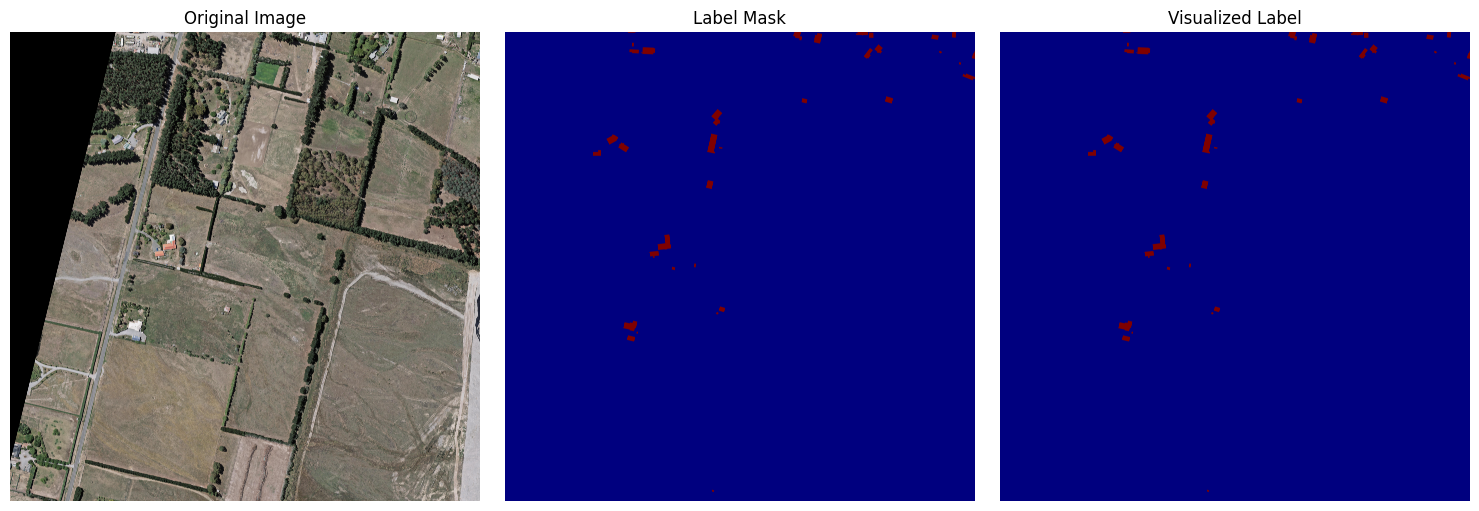

In [3]:
img_id = 10

with rasterio.open(f"data\\train\\image\\christchurch_{img_id}.tif") as src:
    img = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}.tif") as src:
    label = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}_vis.tif") as src:
    label_vis = src.read()
    

# Create figure
plt.figure(figsize=(15, 5))

# Plot 1: Original Image (RGB)
plt.subplot(1, 3, 1)
if img.shape[0] == 3:  # If RGB image
    plt.imshow(img.transpose(1, 2, 0))  # Convert from (C,H,W) to (H,W,C)
else:  # If single channel
    plt.imshow(img[0], cmap='gray')  # Show first band
plt.title("Original Image")
plt.axis('off')

# Plot 2: Label Mask
plt.subplot(1, 3, 2)
if len(label.shape) == 3:
    plt.imshow(label[0], cmap='jet')  # Show first band of label
else:
    plt.imshow(label, cmap='jet')
plt.title("Label Mask")
plt.axis('off')

# Plot 3: Visualized Label
plt.subplot(1, 3, 3)
if label_vis.shape[0] == 3:  # If RGB
    plt.imshow(label_vis.transpose(1, 2, 0))
else:  # If single channel
    plt.imshow(label_vis[0], cmap='jet')
plt.title("Visualized Label")
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
print(img.shape, label.shape, label_vis.shape)

(3, 10000, 10000) (1, 10000, 10000) (1, 10000, 10000)


In [5]:
img.min(), img.max()

(np.uint8(0), np.uint8(255))

## **Deep Learning Test**

### **Patch Process Test**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = MultiFileRoofDataset(
    img_dir="data/train/image",
    mask_dir="data/train/label",
    patch_size=512,
    stride=256,
    augment=True,
    subset_size=400
)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

val_data = MultiFileRoofDataset(
    img_dir="data/val/image",
    mask_dir="data/val/label",
    patch_size=512,
    stride=256,
    augment=True,
    subset_size=100
)
train_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=32,
    shuffle=True,
    num_workers=4
)


In [7]:
INPUT_SIZE = 512

In [8]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(CNN, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)  # (1, 16, 512, 512)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (1, 32, 512, 512)
        self.pool = nn.MaxPool2d(2, 2)  # (1, 32, 256, 256)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Down to 128x128

        # Bottleneck
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Up to 256x256
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # Up to 512x512
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        # Output Layer (Same size as input)
        self.final_conv = nn.Conv2d(8, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))

        x3 = F.relu(self.conv3(x2))
        x4 = self.pool2(F.relu(x3))

        # Bottleneck
        x5 = F.relu(self.conv4(x4))

        # Decoding
        x6 = F.relu(self.upconv1(x5))  # Up to 256x256
        x6 = F.relu(self.conv5(x6))

        x7 = F.relu(self.upconv2(x6))  # Up to 512x512
        x7 = F.relu(self.conv6(x7))

        # Final Output (Mask)
        x_out = torch.sigmoid(self.final_conv(x7))  # Binary mask output
        return x_out



In [9]:
from torchsummary import summary

# Example usage
model = CNN()
print(f"Summary: {summary(model, input_size=(3,512,512))}")
sample_input = torch.randn(1, 3, 512, 512)  # Batch size 1, RGB image
output = model(sample_input)
print(output.shape)  # Should be (1, 1, 512, 512)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             448
            Conv2d-2         [-1, 32, 512, 512]           4,640
         MaxPool2d-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          18,496
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
   ConvTranspose2d-7         [-1, 64, 256, 256]          32,832
            Conv2d-8         [-1, 32, 256, 256]          18,464
   ConvTranspose2d-9         [-1, 16, 512, 512]           2,064
           Conv2d-10          [-1, 8, 512, 512]           1,160
           Conv2d-11          [-1, 1, 512, 512]               9
Total params: 151,969
Trainable params: 151,969
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-2, device="cpu"):
    """
    Train the CNN model for image segmentation.

    Parameters:
    - model: PyTorch model (CNN)
    - train_loader: DataLoader for training set
    - val_loader: DataLoader for validation set
    - num_epochs: Number of epochs
    - learning_rate: Initial learning rate
    - device: "cuda" or "cpu"

    Returns:
    - Trained model
    """
    # Move model to GPU/CPU
    model.to(device)
    
    # Loss function: Binary Cross-Entropy for binary segmentation
    criterion = nn.BCELoss()  # Use nn.CrossEntropyLoss() for multi-class masks

    # Optimizer: Adam with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning Rate Scheduler (optional)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0
        # Initialize tqdm progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)  # Move to GPU

            optimizer.zero_grad()  # Reset gradients
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Compute loss

            loss.backward()  # Backpropagation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()  # Update weights

            epoch_loss += loss.item()
            
            # Update tqdm description with current loss
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Adjust learning rate
        scheduler.step()

        # Print epoch stats
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

        # Validation (Optional)
        if val_loader:
            validate_model(model, val_loader, criterion, device)

    return model

@torch.no_grad()
def validate_model(model, val_loader, criterion, device="cpu"):
    """
    Validate model on the validation dataset.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    

@torch.no_grad()
def predict(model, input_data, device="cpu", threshold=None):
    """
    Make predictions using the trained model.

    Parameters:
    - model: Trained PyTorch model
    - input_data: Can be one of:
        * Single image (3D tensor [C, H, W])
        * Batch of images (4D tensor [B, C, H, W])
        * PIL Image (will be converted to tensor)
        * numpy array (will be converted to tensor)
    - device: "cuda" or "cpu"
    - threshold: If provided (0-1), probabilities will be thresholded to create binary masks

    Returns:
    - Predicted masks as numpy array with same shape as input (without batch dimension)
    """
    
    # Store original input type to return consistent output
    input_type = type(input_data)
    
    # Convert different input types to tensor
    if isinstance(input_data, (Image.Image, np.ndarray)):
        transform = transforms.ToTensor()
        input_data = transform(input_data).unsqueeze(0)  # Add batch dimension
    elif isinstance(input_data, torch.Tensor):
        if input_data.dim() == 3:  # Single image [C,H,W]
            input_data = input_data.unsqueeze(0)  # Add batch dimension
    else:
        raise ValueError("Input must be PIL Image, numpy array, or torch tensor")
    
    # Move to device and make prediction
    model.eval()
    input_data = input_data.to(device)
    output = model(input_data)
    
    # Apply threshold if provided
    if threshold is not None:
        output = (output > threshold).float()
    
    # Convert to numpy and remove batch dimension if input didn't have one
    output = output.squeeze().cpu().numpy()  # Removes batch dim if batch_size=1
    
    # If input was PIL or single image numpy array, ensure we return same shape
    if input_type in (Image.Image, np.ndarray) and output.ndim == 3:
        output = output.squeeze(0)  # Remove channel dim if it's 1
    
    return output


In [11]:
# Assuming you have a DataLoader for training & validation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Create model instance
model = CNN()

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-3)


Epoch [1/50]: 100%|██████████| 13/13 [02:33<00:00, 11.78s/it, loss=0.4097]


Epoch [1/50], Loss: 0.6474
Validation Loss: 0.6094


Epoch [2/50]: 100%|██████████| 13/13 [02:19<00:00, 10.70s/it, loss=0.4398]


Epoch [2/50], Loss: 0.3781
Validation Loss: 0.6257


Epoch [3/50]: 100%|██████████| 13/13 [01:51<00:00,  8.57s/it, loss=0.3808]


Epoch [3/50], Loss: 0.3115
Validation Loss: 0.5438


Epoch [4/50]: 100%|██████████| 13/13 [01:47<00:00,  8.27s/it, loss=0.2796]


Epoch [4/50], Loss: 0.2768
Validation Loss: 0.5260


Epoch [5/50]: 100%|██████████| 13/13 [01:47<00:00,  8.24s/it, loss=0.3225]


Epoch [5/50], Loss: 0.2467
Validation Loss: 0.3820


Epoch [6/50]: 100%|██████████| 13/13 [35:31<00:00, 163.95s/it, loss=0.3684]


Epoch [6/50], Loss: 0.2311
Validation Loss: 0.3374


Epoch [7/50]: 100%|██████████| 13/13 [02:09<00:00,  9.94s/it, loss=0.2398]


Epoch [7/50], Loss: 0.2203
Validation Loss: 0.3324


Epoch [8/50]: 100%|██████████| 13/13 [02:39<00:00, 12.24s/it, loss=0.2538]


Epoch [8/50], Loss: 0.2188
Validation Loss: 0.3095


Epoch [9/50]: 100%|██████████| 13/13 [02:41<00:00, 12.40s/it, loss=0.2349]


Epoch [9/50], Loss: 0.2167
Validation Loss: 0.3036


Epoch [10/50]: 100%|██████████| 13/13 [02:40<00:00, 12.37s/it, loss=0.1880]


Epoch [10/50], Loss: 0.2176
Validation Loss: 0.2988


Epoch [11/50]: 100%|██████████| 13/13 [02:52<00:00, 13.26s/it, loss=0.1493]


Epoch [11/50], Loss: 0.2102
Validation Loss: 0.3236


Epoch [12/50]: 100%|██████████| 13/13 [03:20<00:00, 15.43s/it, loss=0.0944]


Epoch [12/50], Loss: 0.2002
Validation Loss: 0.2922


Epoch [13/50]: 100%|██████████| 13/13 [02:38<00:00, 12.19s/it, loss=0.1969]


Epoch [13/50], Loss: 0.2036
Validation Loss: 0.3060


Epoch [14/50]: 100%|██████████| 13/13 [03:00<00:00, 13.91s/it, loss=0.2031]


Epoch [14/50], Loss: 0.2021
Validation Loss: 0.2893


Epoch [15/50]: 100%|██████████| 13/13 [02:50<00:00, 13.15s/it, loss=0.2192]


Epoch [15/50], Loss: 0.2011
Validation Loss: 0.2856


Epoch [16/50]: 100%|██████████| 13/13 [03:07<00:00, 14.43s/it, loss=0.2242]


Epoch [16/50], Loss: 0.1998
Validation Loss: 0.2926


Epoch [17/50]: 100%|██████████| 13/13 [04:02<00:00, 18.66s/it, loss=0.1402]


Epoch [17/50], Loss: 0.1951
Validation Loss: 0.2837


Epoch [18/50]: 100%|██████████| 13/13 [02:25<00:00, 11.23s/it, loss=0.2977]


Epoch [18/50], Loss: 0.2005
Validation Loss: 0.2813


Epoch [19/50]: 100%|██████████| 13/13 [02:36<00:00, 12.05s/it, loss=0.1650]


Epoch [19/50], Loss: 0.1941
Validation Loss: 0.2896


Epoch [20/50]: 100%|██████████| 13/13 [02:39<00:00, 12.26s/it, loss=0.2286]


Epoch [20/50], Loss: 0.1958
Validation Loss: 0.2739


Epoch [21/50]: 100%|██████████| 13/13 [02:31<00:00, 11.67s/it, loss=0.1552]


Epoch [21/50], Loss: 0.1921
Validation Loss: 0.2750


Epoch [22/50]: 100%|██████████| 13/13 [02:10<00:00, 10.07s/it, loss=0.2113]


Epoch [22/50], Loss: 0.1938
Validation Loss: 0.2778


Epoch [23/50]: 100%|██████████| 13/13 [02:20<00:00, 10.80s/it, loss=0.1813]


Epoch [23/50], Loss: 0.1914
Validation Loss: 0.2725


Epoch [24/50]: 100%|██████████| 13/13 [02:26<00:00, 11.27s/it, loss=0.2347]


Epoch [24/50], Loss: 0.1938
Validation Loss: 0.2792


Epoch [25/50]: 100%|██████████| 13/13 [01:37<00:00,  7.51s/it, loss=0.1602]


Epoch [25/50], Loss: 0.1910
Validation Loss: 0.2691


Epoch [26/50]: 100%|██████████| 13/13 [01:31<00:00,  7.03s/it, loss=0.1511]


Epoch [26/50], Loss: 0.1885
Validation Loss: 0.2723


Epoch [27/50]: 100%|██████████| 13/13 [01:20<00:00,  6.18s/it, loss=0.1811]


Epoch [27/50], Loss: 0.1897
Validation Loss: 0.2745


Epoch [28/50]: 100%|██████████| 13/13 [01:18<00:00,  6.03s/it, loss=0.1483]


Epoch [28/50], Loss: 0.1875
Validation Loss: 0.2699


Epoch [29/50]: 100%|██████████| 13/13 [01:25<00:00,  6.54s/it, loss=0.1233]


Epoch [29/50], Loss: 0.1859
Validation Loss: 0.2715


Epoch [30/50]: 100%|██████████| 13/13 [01:27<00:00,  6.74s/it, loss=0.2197]


Epoch [30/50], Loss: 0.1892
Validation Loss: 0.2690


Epoch [31/50]: 100%|██████████| 13/13 [01:18<00:00,  6.01s/it, loss=0.2315]


Epoch [31/50], Loss: 0.1896
Validation Loss: 0.2677


Epoch [32/50]: 100%|██████████| 13/13 [01:36<00:00,  7.39s/it, loss=0.2313]


Epoch [32/50], Loss: 0.1887
Validation Loss: 0.2689


Epoch [33/50]: 100%|██████████| 13/13 [01:39<00:00,  7.68s/it, loss=0.1084]


Epoch [33/50], Loss: 0.1840
Validation Loss: 0.2691


Epoch [34/50]: 100%|██████████| 13/13 [01:18<00:00,  6.06s/it, loss=0.1980]


Epoch [34/50], Loss: 0.1872
Validation Loss: 0.2670


Epoch [35/50]: 100%|██████████| 13/13 [01:18<00:00,  6.06s/it, loss=0.0900]


Epoch [35/50], Loss: 0.1827
Validation Loss: 0.2675


Epoch [36/50]: 100%|██████████| 13/13 [01:18<00:00,  6.04s/it, loss=0.2166]


Epoch [36/50], Loss: 0.1874
Validation Loss: 0.2669


Epoch [37/50]: 100%|██████████| 13/13 [01:21<00:00,  6.24s/it, loss=0.1779]


Epoch [37/50], Loss: 0.1857
Validation Loss: 0.2663


Epoch [38/50]: 100%|██████████| 13/13 [01:18<00:00,  6.02s/it, loss=0.2853]


Epoch [38/50], Loss: 0.1899
Validation Loss: 0.2672


Epoch [39/50]: 100%|██████████| 13/13 [01:18<00:00,  6.01s/it, loss=0.3399]


Epoch [39/50], Loss: 0.1917
Validation Loss: 0.2670


Epoch [40/50]: 100%|██████████| 13/13 [01:18<00:00,  6.07s/it, loss=0.1023]


Epoch [40/50], Loss: 0.1824
Validation Loss: 0.2663


Epoch [41/50]: 100%|██████████| 13/13 [01:18<00:00,  6.00s/it, loss=0.2282]


Epoch [41/50], Loss: 0.1872
Validation Loss: 0.2656


Epoch [42/50]: 100%|██████████| 13/13 [01:18<00:00,  6.03s/it, loss=0.1271]


Epoch [42/50], Loss: 0.1833
Validation Loss: 0.2656


Epoch [43/50]: 100%|██████████| 13/13 [01:21<00:00,  6.25s/it, loss=0.2260]


Epoch [43/50], Loss: 0.1869
Validation Loss: 0.2662


Epoch [44/50]: 100%|██████████| 13/13 [01:27<00:00,  6.76s/it, loss=0.1143]


Epoch [44/50], Loss: 0.1825
Validation Loss: 0.2663


Epoch [45/50]: 100%|██████████| 13/13 [01:46<00:00,  8.18s/it, loss=0.2709]


Epoch [45/50], Loss: 0.1885
Validation Loss: 0.2663


Epoch [46/50]: 100%|██████████| 13/13 [01:49<00:00,  8.46s/it, loss=0.1749]


Epoch [46/50], Loss: 0.1847
Validation Loss: 0.2657


Epoch [47/50]: 100%|██████████| 13/13 [01:20<00:00,  6.19s/it, loss=0.1458]


Epoch [47/50], Loss: 0.1836
Validation Loss: 0.2658


Epoch [48/50]: 100%|██████████| 13/13 [01:19<00:00,  6.09s/it, loss=0.1335]


Epoch [48/50], Loss: 0.1832
Validation Loss: 0.2662


Epoch [49/50]: 100%|██████████| 13/13 [01:31<00:00,  7.05s/it, loss=0.3149]


Epoch [49/50], Loss: 0.1901
Validation Loss: 0.2660


Epoch [50/50]: 100%|██████████| 13/13 [01:27<00:00,  6.73s/it, loss=0.1748]


Epoch [50/50], Loss: 0.1846
Validation Loss: 0.2658


In [12]:
def predict_large_image(model, image_path, patch_size=512, stride=256, device="cpu", threshold=None):
    """Predict on large geospatial images using sliding window"""
    with rasterio.open(image_path) as src:
        # Check number of bands and ensure proper channel order
        if src.count not in [1, 3]:
            raise ValueError("Image must have 1 or 3 bands (grayscale or RGB)")
            
        height, width = src.height, src.width
        output = np.zeros((height, width), dtype=np.float32)
        counts = np.zeros((height, width), dtype=np.float32)
        
        for x in range(0, width, stride):
            for y in range(0, height, stride):
                # Handle edge cases
                win_width = min(patch_size, width - x)
                win_height = min(patch_size, height - y)
                window = Window(x, y, win_width, win_height)
                
                # Read and normalize patch [C, H, W]
                patch = src.read(window=window).astype('float32') / 255.0
                
                # Convert single-channel to 3-channel if needed
                if patch.shape[0] == 1:
                    patch = np.repeat(patch, 3, axis=0)
                
                # Pad if smaller than patch_size
                if patch.shape[1] < patch_size or patch.shape[2] < patch_size:
                    pad_h = patch_size - patch.shape[1]
                    pad_w = patch_size - patch.shape[2]
                    patch = np.pad(patch, ((0,0), (0,pad_h), (0,pad_w)), mode='reflect')
                
                # Convert to [1, C, H, W] and predict
                patch_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)
                with torch.no_grad():
                    pred = model(patch_tensor)
                pred_patch = pred.squeeze().cpu().numpy()
                
                # Aggregate only the valid region
                output[y:y+win_height, x:x+win_width] += pred_patch[:win_height, :win_width]
                counts[y:y+win_height, x:x+win_width] += 1
        
        # Average overlapping regions
        output = np.divide(output, counts, where=counts>0)
        
        return (output > threshold).astype(np.uint8) if threshold else output
    
# For single patch prediction
# img, mask = val_data[0]  # Get first sample
# pred = predict(trained_model, img, device="cpu", threshold=0.5)

In [ ]:
def visualize_prediction(image_path, prediction, figsize=(15, 10)):
    """
    Visualize original image, prediction mask, and overlay side-by-side
    
    Args:
        image_path: Path to original geospatial image
        prediction: Numpy array of predictions (H,W)
        figsize: Figure size (width, height)
    """
    # Open original image
    with rasterio.open(image_path) as src:
        img = src.read()
        
        # Handle single-channel images
        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)  # Convert to RGB
        elif img.shape[0] > 3:  # If multiband, take first 3 bands
            img = img[:3]
        
        # Normalize image for display
        img = np.moveaxis(img, 0, -1)  # Change from (C,H,W) to (H,W,C)
        img = (img - img.min()) / (img.max() - img.min())
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    # Original Image
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Prediction Mask
    ax2.imshow(prediction, cmap='viridis')
    ax2.set_title('Prediction Mask')
    ax2.axis('off')
    
    # Overlay
    ax3.imshow(img)
    ax3.imshow(prediction, cmap='jet', alpha=0.4)  # 40% transparency
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

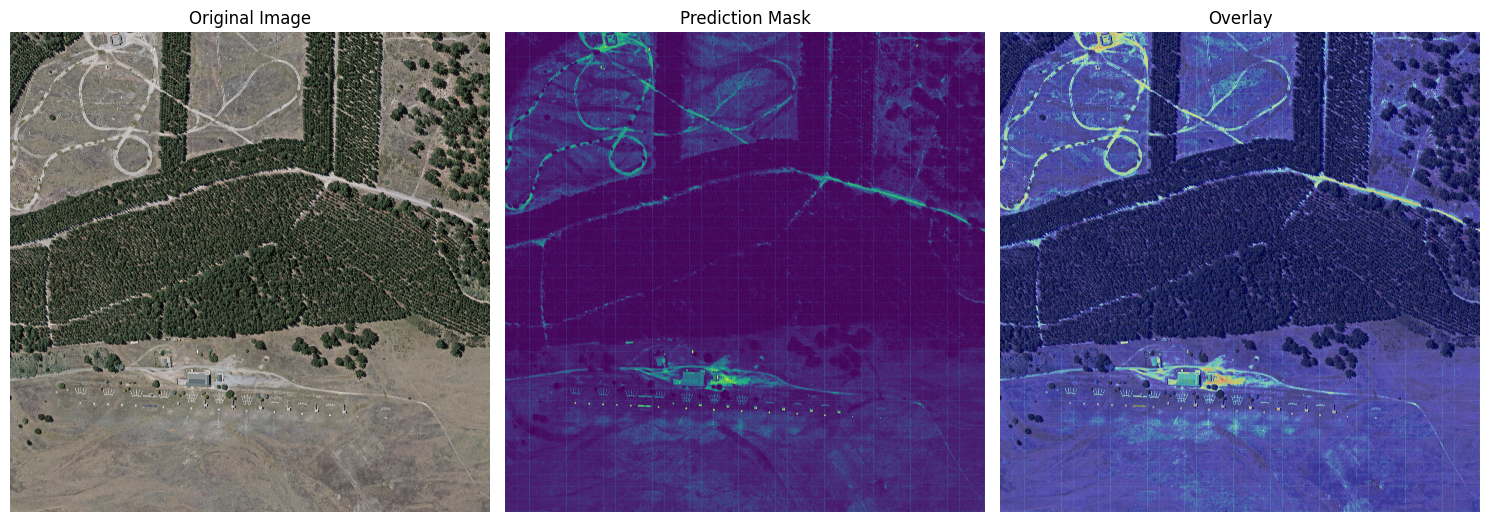

In [14]:
img_id = 30 

# For full image prediction
full_pred = predict_large_image(trained_model, f"data\\train\\image\\christchurch_{img_id}.tif", 
                              patch_size=512, 
                              stride=256,
                              device="cpu")
# Usage Example:
visualize_prediction(f"data\\train\\image\\christchurch_{img_id}.tif", full_pred)

In [15]:
200/len(os.listdir(os.getcwd() + "\\data\\train\\image")) # Roughly 20% of the data and using a simple model to reduce computation 

0.23337222870478413

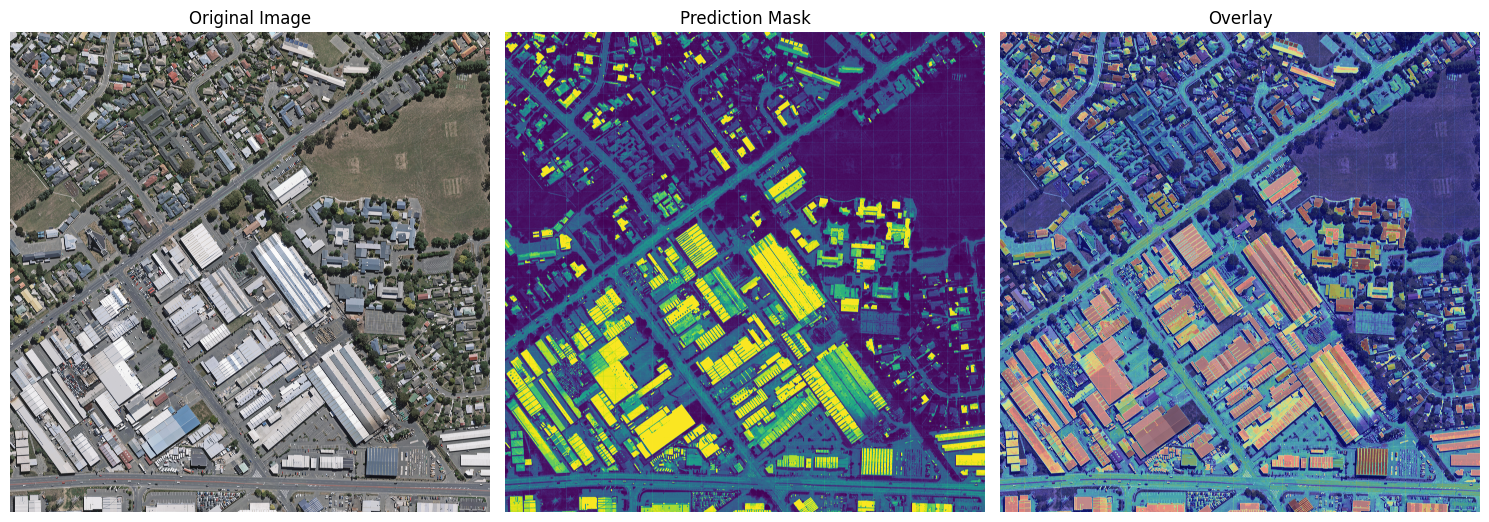

In [16]:
img_id = 333

# For full image prediction
full_pred = predict_large_image(trained_model, f"data\\train\\image\\christchurch_{img_id}.tif", 
                              patch_size=512, 
                              stride=256,
                              device="cpu")
# Usage Example:
visualize_prediction(f"data\\train\\image\\christchurch_{img_id}.tif", full_pred)

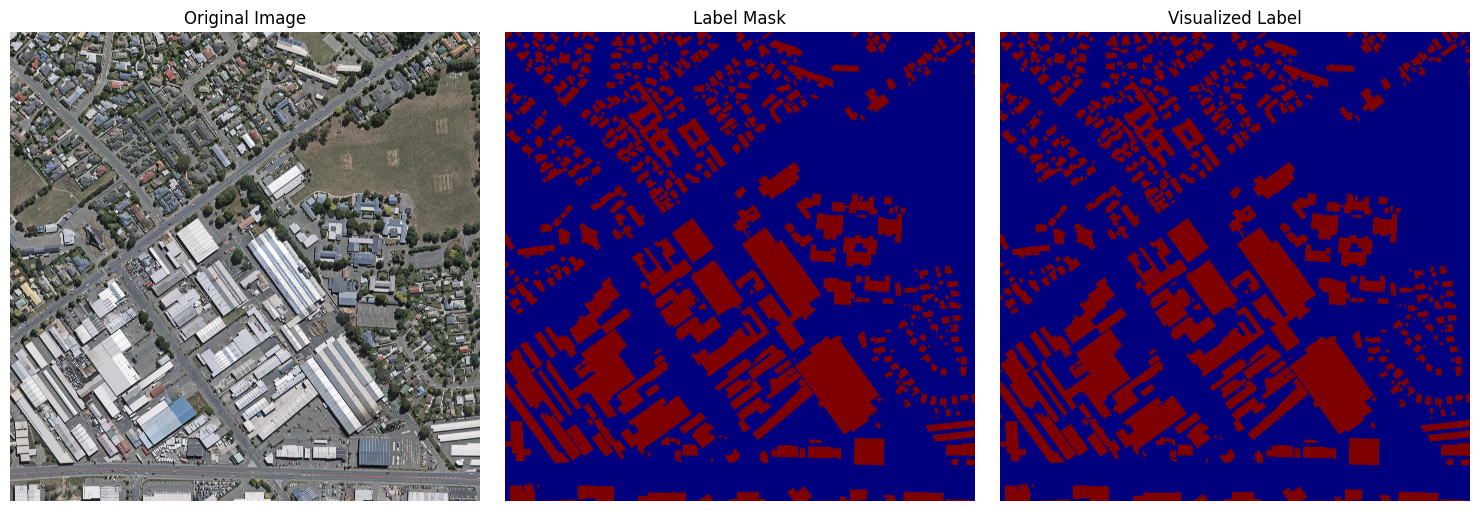

In [17]:
img_id = 333

with rasterio.open(f"data\\train\\image\\christchurch_{img_id}.tif") as src:
    img = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}.tif") as src:
    label = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}_vis.tif") as src:
    label_vis = src.read()
    

# Create figure
plt.figure(figsize=(15, 5))

# Plot 1: Original Image (RGB)
plt.subplot(1, 3, 1)
if img.shape[0] == 3:  # If RGB image
    plt.imshow(img.transpose(1, 2, 0))  # Convert from (C,H,W) to (H,W,C)
else:  # If single channel
    plt.imshow(img[0], cmap='gray')  # Show first band
plt.title("Original Image")
plt.axis('off')

# Plot 2: Label Mask
plt.subplot(1, 3, 2)
if len(label.shape) == 3:
    plt.imshow(label[0], cmap='jet')  # Show first band of label
else:
    plt.imshow(label, cmap='jet')
plt.title("Label Mask")
plt.axis('off')

# Plot 3: Visualized Label
plt.subplot(1, 3, 3)
if label_vis.shape[0] == 3:  # If RGB
    plt.imshow(label_vis.transpose(1, 2, 0))
else:  # If single channel
    plt.imshow(label_vis[0], cmap='jet')
plt.title("Visualized Label")
plt.axis('off')

plt.tight_layout()
plt.show()

## **Testing with Checkpoint**

Run imports block at the top of the notebook then run all cells after this markdown.

In [2]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(CNN, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)  # (1, 16, 512, 512)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (1, 32, 512, 512)
        self.pool = nn.MaxPool2d(2, 2)  # (1, 32, 256, 256)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Down to 128x128

        # Bottleneck
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Up to 256x256
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # Up to 512x512
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        # Output Layer (Same size as input)
        self.final_conv = nn.Conv2d(8, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))

        x3 = F.relu(self.conv3(x2))
        x4 = self.pool2(F.relu(x3))

        # Bottleneck
        x5 = F.relu(self.conv4(x4))

        # Decoding
        x6 = F.relu(self.upconv1(x5))  # Up to 256x256
        x6 = F.relu(self.conv5(x6))

        x7 = F.relu(self.upconv2(x6))  # Up to 512x512
        x7 = F.relu(self.conv6(x7))

        # Final Output (Mask)
        x_out = torch.sigmoid(self.final_conv(x7))  # Binary mask output
        return x_out



In [3]:
def predict_large_image(model, image_path, patch_size=512, stride=256, device="cpu", threshold=None):
    """Predict on large geospatial images using sliding window"""
    with rasterio.open(image_path) as src:
        # Check number of bands and ensure proper channel order
        if src.count not in [1, 3]:
            raise ValueError("Image must have 1 or 3 bands (grayscale or RGB)")
            
        height, width = src.height, src.width
        output = np.zeros((height, width), dtype=np.float32)
        counts = np.zeros((height, width), dtype=np.float32)
        
        for x in range(0, width, stride):
            for y in range(0, height, stride):
                # Handle edge cases
                win_width = min(patch_size, width - x)
                win_height = min(patch_size, height - y)
                window = Window(x, y, win_width, win_height)
                
                # Read and normalize patch [C, H, W]
                patch = src.read(window=window).astype('float32') / 255.0
                
                # Convert single-channel to 3-channel if needed
                if patch.shape[0] == 1:
                    patch = np.repeat(patch, 3, axis=0)
                
                # Pad if smaller than patch_size
                if patch.shape[1] < patch_size or patch.shape[2] < patch_size:
                    pad_h = patch_size - patch.shape[1]
                    pad_w = patch_size - patch.shape[2]
                    patch = np.pad(patch, ((0,0), (0,pad_h), (0,pad_w)), mode='reflect')
                
                # Convert to [1, C, H, W] and predict
                patch_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)
                with torch.no_grad():
                    pred = model(patch_tensor)
                pred_patch = pred.squeeze().cpu().numpy()
                
                # Aggregate only the valid region
                output[y:y+win_height, x:x+win_width] += pred_patch[:win_height, :win_width]
                counts[y:y+win_height, x:x+win_width] += 1
        
        # Average overlapping regions
        output = np.divide(output, counts, where=counts>0)
        
        return (output > threshold).astype(np.uint8) if threshold else output
    
# For single patch prediction
# img, mask = val_data[0]  # Get first sample
# pred = predict(trained_model, img, device="cpu", threshold=0.5)
def visualize_prediction(image_path, prediction, figsize=(15, 10)):
    """
    Visualize original image, prediction mask, and overlay side-by-side
    
    Args:
        image_path: Path to original geospatial image
        prediction: Numpy array of predictions (H,W)
        figsize: Figure size (width, height)
    """
    # Open original image
    with rasterio.open(image_path) as src:
        img = src.read()
        
        # Handle single-channel images
        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)  # Convert to RGB
        elif img.shape[0] > 3:  # If multiband, take first 3 bands
            img = img[:3]
        
        # Normalize image for display
        img = np.moveaxis(img, 0, -1)  # Change from (C,H,W) to (H,W,C)
        img = (img - img.min()) / (img.max() - img.min())
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    # Original Image
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Prediction Mask
    ax2.imshow(prediction, cmap='viridis')
    ax2.set_title('Prediction Mask')
    ax2.axis('off')
    
    # Overlay
    ax3.imshow(img)
    ax3.imshow(prediction, cmap='jet', alpha=0.4)  # 40% transparency
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
# Load with:
checkpoint = torch.load('checkpoint.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

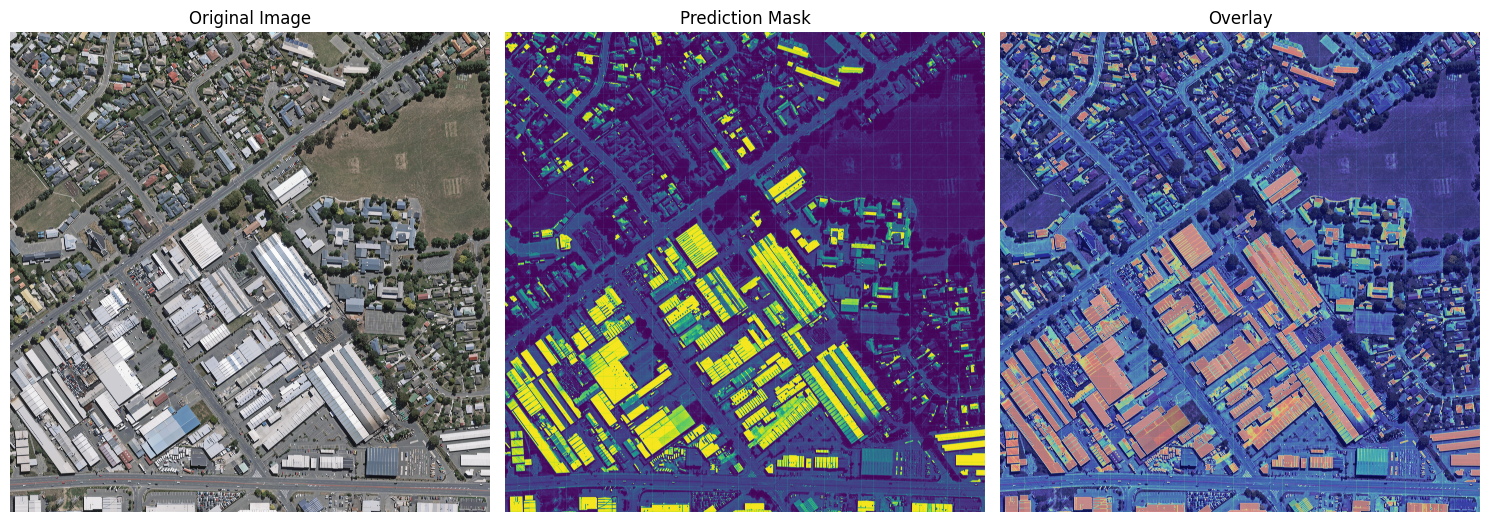

In [ ]:
img_id = 333

# For full image prediction
full_pred = predict_large_image(model, f"data\\train\\image\\christchurch_{img_id}.tif", 
                              patch_size=512, 
                              stride=256,
                              device="cpu")
# Usage Example:
visualize_prediction(f"data\\train\\image\\christchurch_{img_id}.tif", full_pred)

In [ ]:
from rasterio.io import MemoryFile

input_path = "Z:\\Client\\Kier Construction\\Tain Campus\\Kier Tain Campus UAV Topo\\Kier Tain Campus Drainage Survey DSM.Ortho_0.tif"
output_path = "C:\\Users\\Admin\\PythonProjects\\RoofDetection\\RoofDetection\\tif3band.tif"
def convert_to_3bands(input_path, output_path):
    # Open original file
    with rasterio.open(input_path) as src:
        # Read the first three bands
        bands = [src.read(i) for i in range(1, 4)]

        # Copy metadata and update band count
        meta = src.meta.copy()
        meta.update(count=3)

        # Write new file with only the first 3 bands
        with rasterio.open(output_path, "w", **meta) as dst:
            for i, band in enumerate(bands, start=1):
                dst.write(band, i)


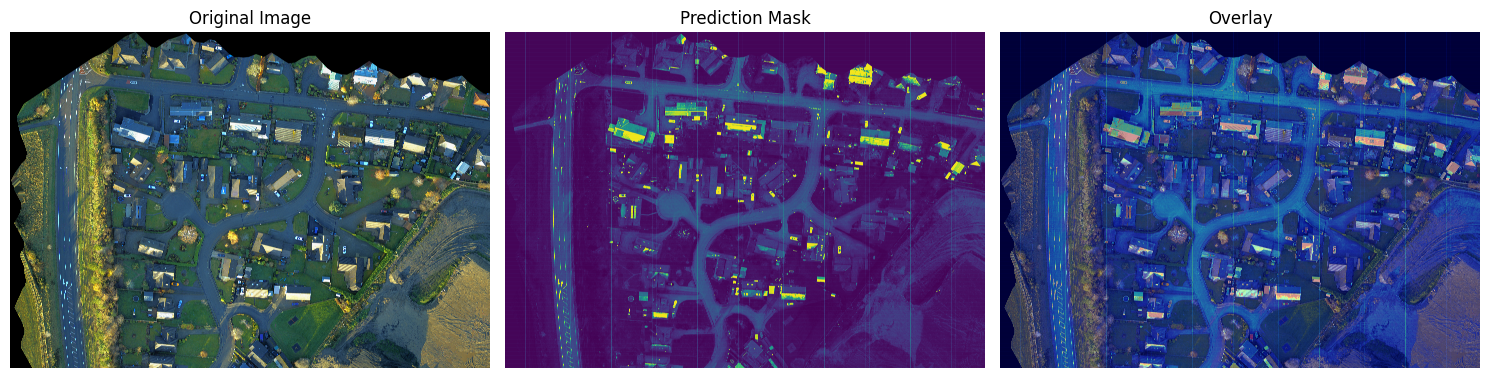

In [ ]:

# For full image prediction
full_pred = predict_large_image(model, output_path,
                              patch_size=512, 
                              stride=256,
                              device="cpu")
# Usage Example:
visualize_prediction(output_path, full_pred)